In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load datasets
train_df = pd.read_csv('../data/Train.csv')
test_df = pd.read_csv('../data/Test.csv')

# Display basic info
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [88]:
# Checking for missing values
train_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [89]:
# Filling missing Item_Weight using median per Item_Identifier
train_df['Item_Weight'] = train_df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.median()))

In [90]:
# Extract main category of Item_Identifier
train_df['Item_Group'] = train_df['Item_Identifier'].str[:2]

In [91]:
train_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Group
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,FD
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,FD
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850,FD
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,NC
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,FD


In [92]:
# Compute MRP_per_Weight for non-null Item_Weights
train_df['MRP_per_unit_Weight'] = train_df['Item_MRP'] / train_df['Item_Weight']

# Calculate the median MRP_per_Weight for each Item_Group
mrp_weight_median = train_df.groupby('Item_Group')['MRP_per_unit_Weight'].median()

# Identify missing Item_Weight rows
missing_weight_mask = train_df['Item_Weight'].isna()

# Estimate missing weights using the median MRP_per_Weight from the same Item_Group
train_df.loc[missing_weight_mask, 'Item_Weight'] = train_df.loc[missing_weight_mask].apply(
    lambda row: row['Item_MRP'] / mrp_weight_median.get(row['Item_Group'], np.nan), axis=1
)

# Update MRP_per_unit_Weight for all rows (since we filled missing weights)
train_df['MRP_per_unit_Weight'] = train_df['Item_MRP'] / train_df['Item_Weight']


In [93]:
# Filling missing Item_Weight using median per Item_Identifier

# Compute median Item_Weight per Item_Identifier from train_df
item_weight_medians = train_df.groupby('Item_Identifier')['Item_Weight'].median()

# Map those values to test_df, filling missing values
test_df['Item_Weight'] = test_df['Item_Identifier'].map(item_weight_medians)


In [94]:
test_df[test_df["Item_Weight"].isnull()]["Item_Identifier"]

Series([], Name: Item_Identifier, dtype: object)

In [95]:
# Identifying unique Outlet_Identifiers with missing Outlet_Size
missing_size_outlets = train_df[train_df['Outlet_Size'].isna()]['Outlet_Identifier'].unique()

# Map missing Outlet_Size values based on observed trends
outlet_size_mapping = {
    'OUT010': 'Small',  # Grocery Store → Always Small
    'OUT045': 'Small',  # Tier 2, Supermarket Type1 → Small (based on other entries)
    'OUT017': 'Small'   # Tier 2, Supermarket Type1 → Small (based on other entries)
}

# Apply mapping to fill missing Outlet_Size values
train_df['Outlet_Size'] = train_df['Outlet_Size'].fillna(train_df['Outlet_Identifier'].map(outlet_size_mapping))

In [96]:
# Compute the most common Outlet_Size per Outlet_Identifier from train_df
outlet_size_mode = train_df.groupby('Outlet_Identifier')['Outlet_Size'].agg(lambda x: x.mode()[0] if not x.isna().all() else np.nan)

# Map those values to test_df, filling missing Outlet_Size values
test_df['Outlet_Size'] = test_df['Outlet_Size'].fillna(test_df['Outlet_Identifier'].map(outlet_size_mode))


In [97]:
# Standardize Item_Fat_Content values
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

In [98]:
# Convert to lowercase to avoid case mismatches
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].str.lower()

# Standardize values
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].replace({
    'lf': 'Low Fat', 
    'low fat': 'Low Fat', 
    'reg': 'Regular',
    'regular': 'Regular'
})


In [99]:
# Checking for duplicate records
duplicate_rows = train_df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Display duplicate rows if any
if duplicate_rows.sum() > 0:
    print(train_df[duplicate_rows])

Number of duplicate rows: 0


In [100]:
# Checking for duplicate records
duplicate_rows = test_df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Display duplicate rows if any
if duplicate_rows.sum() > 0:
    print(train_df[duplicate_rows])

Number of duplicate rows: 0


In [101]:
# Handling Zero Values in Item_Visibility
# Identify items with zero visibility
zero_visibility_count = (train_df['Item_Visibility'] == 0).sum()
print(f"Number of items with zero visibility: {zero_visibility_count}")

# Compute median visibility for each Item_Identifier
visibility_median = train_df.groupby('Item_Identifier')['Item_Visibility'].median()

# Replace zero values with median visibility
train_df.loc[train_df['Item_Visibility'] == 0, 'Item_Visibility'] = train_df['Item_Identifier'].map(visibility_median)

# Verify updates
print("Zero values in Item_Visibility after replacement:", (train_df['Item_Visibility'] == 0).sum())


Number of items with zero visibility: 526
Zero values in Item_Visibility after replacement: 4


In [102]:
# Handle any remaining zero values by replacing with overall median visibility
overall_visibility_median = train_df['Item_Visibility'].median()
train_df.loc[train_df['Item_Visibility'] == 0, 'Item_Visibility'] = overall_visibility_median

# Verify final updates
print("Zero values in Item_Visibility after final replacement:", (train_df['Item_Visibility'] == 0).sum())


Zero values in Item_Visibility after final replacement: 0


In [103]:
# Handling Zero Values in Item_Visibility
# Identify items with zero visibility
zero_visibility_count = (test_df['Item_Visibility'] == 0).sum()
print(f"Number of items with zero visibility: {zero_visibility_count}")

# Compute median visibility for each Item_Identifier from train_df
visibility_median = train_df.groupby('Item_Identifier')['Item_Visibility'].median()

# Replace zero values in test_df with median visibility from train_df
test_df.loc[test_df['Item_Visibility'] == 0, 'Item_Visibility'] = test_df['Item_Identifier'].map(visibility_median)

# Fill any remaining NaN values with the overall median (in case some Item_Identifiers are missing in train_df)
test_df['Item_Visibility'].fillna(test_df['Item_Visibility'].median(), inplace=True)

# Verify updates
print("Zero values in Item_Visibility after replacement:", (test_df['Item_Visibility'] == 0).sum())


Number of items with zero visibility: 353
Zero values in Item_Visibility after replacement: 0


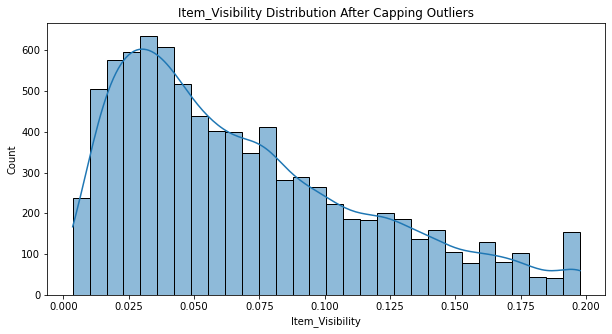

In [104]:
# Capping outliers to the upper bound 

# Calculate IQR
Q1 = train_df["Item_Visibility"].quantile(0.25)
Q3 = train_df["Item_Visibility"].quantile(0.75)
IQR = Q3 - Q1

# Define upper bound (as per IQR method)
upper_bound = Q3 + 1.5 * IQR

# Cap Item_Visibility at upper bound
train_df.loc[train_df["Item_Visibility"] > upper_bound, "Item_Visibility"] = upper_bound

# Plot updated distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df["Item_Visibility"], bins=30, kde=True)
plt.title("Item_Visibility Distribution After Capping Outliers")
plt.xlabel("Item_Visibility")
plt.ylabel("Count")
plt.show()


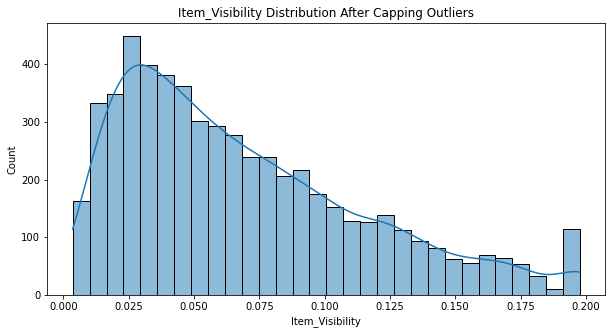

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate IQR from train_df to ensure consistency
Q1 = train_df["Item_Visibility"].quantile(0.25)
Q3 = train_df["Item_Visibility"].quantile(0.75)
IQR = Q3 - Q1

# Define upper bound using IQR method
upper_bound = Q3 + 1.5 * IQR

# Cap Item_Visibility at upper bound in test_df
test_df.loc[test_df["Item_Visibility"] > upper_bound, "Item_Visibility"] = upper_bound

# Plot updated distribution
plt.figure(figsize=(10, 5))
sns.histplot(test_df["Item_Visibility"], bins=30, kde=True)
plt.title("Item_Visibility Distribution After Capping Outliers")
plt.xlabel("Item_Visibility")
plt.ylabel("Count")
plt.show()


In [106]:
# Feature engineering : Feature Extraction : deriving Outlet_Age from Outlet_Establishment_Year

# Dynamically set the reference year based on the latest year in the training data
reference_year = train_df["Outlet_Establishment_Year"].max()

# Calculate Outlet Age by subtracting the establishment year from the current year
train_df["Outlet_Age"] = reference_year - train_df["Outlet_Establishment_Year"]

# Display summary statistics to understand the distribution of Outlet Age
train_df["Outlet_Age"].describe()


count    8523.000000
mean       11.168133
std         8.371760
min         0.000000
25%         5.000000
50%        10.000000
75%        22.000000
max        24.000000
Name: Outlet_Age, dtype: float64

In [107]:

# Feature engineering : Feature Extraction : deriving Outlet_Age from Outlet_Establishment_Year

# Calculate Outlet Age by subtracting the establishment year from the current year
test_df["Outlet_Age"] = reference_year - test_df["Outlet_Establishment_Year"]

# Display summary statistics to understand the distribution of Outlet Age
test_df["Outlet_Age"].describe()

count    5681.000000
mean       11.171097
std         8.372256
min         0.000000
25%         5.000000
50%        10.000000
75%        22.000000
max        24.000000
Name: Outlet_Age, dtype: float64

In [108]:
#Categorizing the items into 3 categories insetad of numerous item_types

def categorize_item_type(df):
    # Define category mappings based on the first two letters of 'Item_Base'
    category_mapping = {
        'NC': 'Non-Consumable',  # Household, Health and Hygiene, Others
        'FD': 'Food',       # Dairy, Meat, Fruits and Vegetables, Baking Goods, etc.
        'DR': 'Drinks'      # Soft Drinks, Hard Drinks, Dairy (if applicable)
    }

    # Create a new column 'Item_Category' based on 'Item_Base'
    df['Item_Category'] = df['Item_Group'].map(category_mapping)

    return df

# Apply function to transform 'Item_Type'
train_df = categorize_item_type(train_df)

# Check results
train_df['Item_Category'].unique()


array(['Food', 'Drinks', 'Non-Consumable'], dtype=object)

In [109]:
def categorize_item_type(df):
    # Ensure 'Item_Base' column exists
    if 'Item_Base' not in df.columns:
        df['Item_Base'] = df['Item_Identifier'].str[:2]  # Extract first two letters

    # Define category mappings based on 'Item_Base'
    category_mapping = {
        'NC': 'Non-Consumable',  
        'FD': 'Food',       
        'DR': 'Drinks'      
    }

    # Map the categories
    df['Item_Category'] = df['Item_Base'].map(category_mapping)

    return df

# Apply transformation
test_df = categorize_item_type(test_df)

# Check results
print(test_df['Item_Category'].unique())


['Food' 'Non-Consumable' 'Drinks']


In [55]:
# Define age bins (including 0 properly)
bins = [-1, 10, 20, float('inf')]  # -1 ensures 0 is included in "New"
labels = ['New', 'Moderate', 'Old']

# Apply binning
train_df['Outlet_Age_Binned'] = pd.cut(train_df['Outlet_Age'], bins=bins, labels=labels)
# Apply the same binning to test_df
test_df['Outlet_Age_Binned'] = pd.cut(test_df['Outlet_Age'], bins=bins, labels=labels)



In [16]:
train_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Group,MRP_per_unit_Weight,Outlet_Age,Item_Category,Outlet_Age_Binned
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD,26.861204,10,Food,New
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR,8.153581,0,Drinks,New
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD,8.092457,10,Food,New
3,FDX07,19.200,Regular,0.022861,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,FD,9.484115,11,Food,Moderate
4,NCD19,8.930,Low Fat,0.006590,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC,6.031512,22,Non-Consumable,Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,FD,31.248623,22,Food,Old
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850,FD,12.906563,7,Food,New
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,NC,8.030415,5,Non-Consumable,New
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,FD,14.304189,0,Food,New


In [110]:
# Compute total sales per outlet
train_df["Outlet_Total_Sales"] = train_df.groupby("Outlet_Identifier")["Item_Outlet_Sales"].transform("sum")


In [111]:
# Map Outlet_Total_Sales from train_df to test_df
outlet_sales_mapping = train_df.groupby("Outlet_Identifier")["Item_Outlet_Sales"].sum()
test_df["Outlet_Total_Sales"] = test_df["Outlet_Identifier"].map(outlet_sales_mapping)

# Fill missing values with 0 (if an outlet in test_df wasn't in train_df)
test_df["Outlet_Total_Sales"] = test_df["Outlet_Total_Sales"].fillna(0)


In [18]:
from category_encoders import TargetEncoder

def target_encode_outlet_sales_train(df, target_col='Outlet_Total_Sales'):
    encoder = TargetEncoder(cols=['Outlet_Identifier'])
    df['Outlet_Identifier_Encoded'] = encoder.fit_transform(df['Outlet_Identifier'], df[target_col])
    
    # Drop `Outlet_Total_Sales` since it's now encoded into `Outlet_Identifier_Encoded`
    #df = df.drop(columns=['Outlet_Total_Sales'])
    
    return df, encoder  # Return both transformed df and fitted encoder

def target_encode_outlet_sales_test(df, encoder):
    df['Outlet_Identifier_Encoded'] = encoder.transform(df['Outlet_Identifier'])
    return df

# Apply target encoding & remove `Outlet_Total_Sales`
train_df, outlet_sales_encoder = target_encode_outlet_sales_train(train_df)


In [57]:
# Apply target encoding to test data
test_df = target_encode_outlet_sales_test(test_df, outlet_sales_encoder)

# Drop `Outlet_Total_Sales` since it was used for encoding
test_df = test_df.drop(columns=['Outlet_Total_Sales'], errors='ignore')


In [19]:
train_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Group,MRP_per_unit_Weight,Outlet_Age,Item_Category,Outlet_Age_Binned,Outlet_Total_Sales,Outlet_Identifier_Encoded
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,FD,26.861204,10,Food,New,2.183970e+06,2.183970e+06
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,DR,8.153581,0,Drinks,New,1.851823e+06,1.851823e+06
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,FD,8.092457,10,Food,New,2.183970e+06,2.183970e+06
3,FDX07,19.200,Regular,0.022861,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,FD,9.484115,11,Food,Moderate,1.883402e+05,1.883402e+05
4,NCD19,8.930,Low Fat,0.006590,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,NC,6.031512,22,Non-Consumable,Old,2.142664e+06,2.142664e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,FD,31.248623,22,Food,Old,2.142664e+06,2.142664e+06
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850,FD,12.906563,7,Food,New,2.036725e+06,2.036725e+06
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,NC,8.030415,5,Non-Consumable,New,2.268123e+06,2.268123e+06
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,FD,14.304189,0,Food,New,1.851823e+06,1.851823e+06


Correlation with target (Encoded): 0.4906
Correlation with target (Original Total Sales): 0.4906


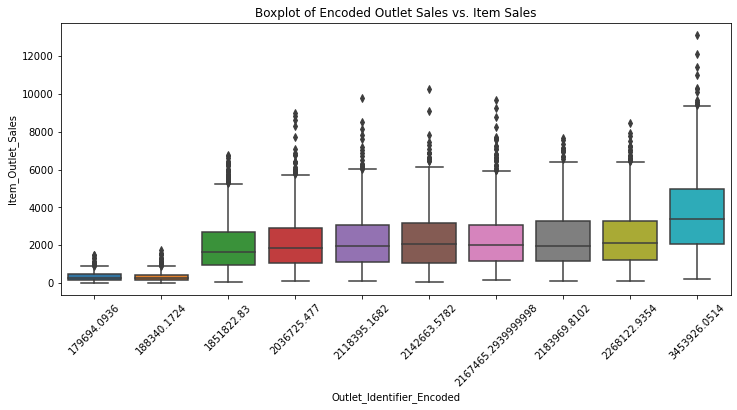

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Compute correlation
correlation_encoded = train_df['Outlet_Identifier_Encoded'].corr(train_df['Item_Outlet_Sales'])
print(f"Correlation with target (Encoded): {correlation_encoded:.4f}")

# (Optional) Compare with original `Outlet_Total_Sales`
if 'Outlet_Total_Sales' in train_df.columns:
    correlation_original = train_df['Outlet_Total_Sales'].corr(train_df['Item_Outlet_Sales'])
    print(f"Correlation with target (Original Total Sales): {correlation_original:.4f}")

# 2️⃣ Visualize distribution
plt.figure(figsize=(12, 5))
sns.boxplot(x=train_df['Outlet_Identifier_Encoded'], y=train_df['Item_Outlet_Sales'])
plt.title("Boxplot of Encoded Outlet Sales vs. Item Sales")
plt.xticks(rotation=45)
plt.show()


In [21]:
print(train_df['Outlet_Age_Binned'].isna().sum())  # Check for NaNs

0


In [22]:
print(train_df['Outlet_Age_Binned'].value_counts())


New         4643
Old         2395
Moderate    1485
Name: Outlet_Age_Binned, dtype: int64


In [23]:
print(train_df.columns)


Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Group', 'MRP_per_unit_Weight',
       'Outlet_Age', 'Item_Category', 'Outlet_Age_Binned',
       'Outlet_Total_Sales', 'Outlet_Identifier_Encoded'],
      dtype='object')


In [24]:
# Compute correlation with target variable
outlet_features = ['Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Age_Binned']
corr_matrix = train_df[outlet_features + ['Outlet_Total_Sales', 'Item_Outlet_Sales']].corr()

# Display correlation values
print(corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False))


Item_Outlet_Sales     1.000000
Outlet_Total_Sales    0.490619
Name: Item_Outlet_Sales, dtype: float64


In [25]:
# Function to encode categorical features using total sales
def encode_using_total_sales(df, feature):
    total_sales_per_category = df.groupby(feature)['Item_Outlet_Sales'].sum()
    return df[feature].map(total_sales_per_category)

# Encode Outlet_Type, Outlet_Size, and Outlet_Location_Type using total sales
outlet_features = ['Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Age', 'Outlet_Age_Binned']

for feature in outlet_features:
    train_df[f"{feature}_Encoded"] = encode_using_total_sales(train_df, feature)
    train_df[f"{feature}_Encoded"] = train_df[f"{feature}_Encoded"].astype(float)

# Compute correlation with target variable
correlation_values = train_df[[f"{feature}_Encoded" for feature in outlet_features] + ['Outlet_Total_Sales', 'Item_Outlet_Sales']].corr()['Item_Outlet_Sales']

# Display sorted correlation values
print(correlation_values.sort_values(ascending=False))

Item_Outlet_Sales               1.000000
Outlet_Total_Sales              0.490619
Outlet_Age_Encoded              0.237368
Outlet_Type_Encoded             0.174697
Outlet_Age_Binned_Encoded       0.107350
Outlet_Location_Type_Encoded    0.098485
Outlet_Size_Encoded            -0.093049
Name: Item_Outlet_Sales, dtype: float64


In [26]:
train_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Outlet_Age,Item_Category,Outlet_Age_Binned,Outlet_Total_Sales,Outlet_Identifier_Encoded,Outlet_Type_Encoded,Outlet_Size_Encoded,Outlet_Location_Type_Encoded,Outlet_Age_Encoded,Outlet_Age_Binned_Encoded
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,10,Food,New,2.183970e+06,2.183970e+06,1.291734e+07,7.489719e+06,4.482059e+06,2.183970e+06,1.050811e+07
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,0,Drinks,New,1.851823e+06,1.851823e+06,1.851823e+06,7.489719e+06,7.636753e+06,1.851823e+06,1.050811e+07
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,10,Food,New,2.183970e+06,2.183970e+06,1.291734e+07,7.489719e+06,4.482059e+06,2.183970e+06,1.050811e+07
3,FDX07,19.200,Regular,0.022861,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,11,Food,Moderate,1.883402e+05,1.883402e+05,3.680343e+05,8.958743e+06,7.636753e+06,1.883402e+05,2.306735e+06
4,NCD19,8.930,Low Fat,0.006590,Household,53.8614,OUT013,1987,High,Tier 3,...,22,Non-Consumable,Old,2.142664e+06,2.142664e+06,1.291734e+07,2.142664e+06,7.636753e+06,2.142664e+06,5.776284e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,...,22,Food,Old,2.142664e+06,2.142664e+06,1.291734e+07,2.142664e+06,7.636753e+06,2.142664e+06,5.776284e+06
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,...,7,Food,New,2.036725e+06,2.036725e+06,1.291734e+07,8.958743e+06,6.472314e+06,2.036725e+06,1.050811e+07
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,...,5,Non-Consumable,New,2.268123e+06,2.268123e+06,1.291734e+07,8.958743e+06,6.472314e+06,2.268123e+06,1.050811e+07
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,...,0,Food,New,1.851823e+06,1.851823e+06,1.851823e+06,7.489719e+06,7.636753e+06,1.851823e+06,1.050811e+07


In [27]:
# Trying interaction encoding

# 1. Outlet_Type × Outlet_Size
# Certain outlet types may be more common in specific sizes (e.g., supermarkets tend to be large).

# 2. Outlet_Type × Outlet_Location_Type
# Some types of outlets may be more prominent in certain locations (e.g., Tier 3 might have more small grocery stores).

# 3. Outlet_Type × Outlet_Age_Binned
# Older outlets might have different sales patterns based on their type (e.g., older supermarkets may have more loyal customers).

# 4. Outlet_Size × Outlet_Age_Binned
# Large, older outlets may have a different sales performance compared to small, newer ones.

# 5. Outlet_Location_Type × Outlet_Age_Binned
# Older outlets in Tier 1 cities may have a different impact than newer ones in Tier 3 cities.

In [28]:
# Convert categorical columns to strings before concatenation
train_df['OutletType_Size'] = train_df['Outlet_Type'].astype(str) + "_" + train_df['Outlet_Size'].astype(str)
train_df['OutletType_Location'] = train_df['Outlet_Type'].astype(str) + "_" + train_df['Outlet_Location_Type'].astype(str)
train_df['OutletType_AgeBinned'] = train_df['Outlet_Type'].astype(str) + "_" + train_df['Outlet_Age_Binned'].astype(str)
train_df['OutletSize_AgeBinned'] = train_df['Outlet_Size'].astype(str) + "_" + train_df['Outlet_Age_Binned'].astype(str)
train_df['OutletLocation_AgeBinned'] = train_df['Outlet_Location_Type'].astype(str) + "_" + train_df['Outlet_Age_Binned'].astype(str)

# Step 2: Encode Interaction Features using Total Sales
interaction_features = ['OutletType_Size', 'OutletType_Location', 'OutletType_AgeBinned', 
                        'OutletSize_AgeBinned', 'OutletLocation_AgeBinned']

def encode_using_total_sales(df, feature):
    total_sales_per_category = df.groupby(feature)['Item_Outlet_Sales'].sum()
    return df[feature].map(total_sales_per_category)

for feature in interaction_features:
    train_df[f"{feature}_Encoded"] = encode_using_total_sales(train_df, feature)

# Step 3: Compute Correlation with Target Variable
correlation_values = train_df[[f"{feature}_Encoded" for feature in interaction_features] + ['Item_Outlet_Sales']].corr()['Item_Outlet_Sales']

# Display sorted correlation values
print(correlation_values.sort_values(ascending=False))


Item_Outlet_Sales                   1.000000
OutletLocation_AgeBinned_Encoded    0.316520
OutletType_Location_Encoded         0.253825
OutletType_AgeBinned_Encoded        0.187629
OutletSize_AgeBinned_Encoded        0.186616
OutletType_Size_Encoded             0.174808
Name: Item_Outlet_Sales, dtype: float64


In [29]:
train_df.columns
train_df.to_csv('train_df_interactive.csv', index=False)

In [30]:
train_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,OutletType_Size,OutletType_Location,OutletType_AgeBinned,OutletSize_AgeBinned,OutletLocation_AgeBinned,OutletType_Size_Encoded,OutletType_Location_Encoded,OutletType_AgeBinned_Encoded,OutletSize_AgeBinned_Encoded,OutletLocation_AgeBinned_Encoded
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,Supermarket Type1_Medium,Supermarket Type1_Tier 1,Supermarket Type1_New,Medium_New,Tier 1_New,2.183970e+06,4.302365e+06,8.656284e+06,4.035793e+06,2.183970e+06
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,Supermarket Type2_Medium,Supermarket Type2_Tier 3,Supermarket Type2_New,Medium_New,Tier 3_New,1.851823e+06,1.851823e+06,1.851823e+06,4.035793e+06,1.851823e+06
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,...,Supermarket Type1_Medium,Supermarket Type1_Tier 1,Supermarket Type1_New,Medium_New,Tier 1_New,2.183970e+06,4.302365e+06,8.656284e+06,4.035793e+06,2.183970e+06
3,FDX07,19.200,Regular,0.022861,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,...,Grocery Store_Small,Grocery Store_Tier 3,Grocery Store_Moderate,Small_Moderate,Tier 3_Moderate,3.680343e+05,1.883402e+05,1.883402e+05,2.306735e+06,1.883402e+05
4,NCD19,8.930,Low Fat,0.006590,Household,53.8614,OUT013,1987,High,Tier 3,...,Supermarket Type1_High,Supermarket Type1_Tier 3,Supermarket Type1_Old,High_Old,Tier 3_Old,2.142664e+06,2.142664e+06,2.142664e+06,2.142664e+06,5.596590e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,...,Supermarket Type1_High,Supermarket Type1_Tier 3,Supermarket Type1_Old,High_Old,Tier 3_Old,2.142664e+06,2.142664e+06,2.142664e+06,2.142664e+06,5.596590e+06
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,...,Supermarket Type1_Small,Supermarket Type1_Tier 2,Supermarket Type1_New,Small_New,Tier 2_New,8.590709e+06,6.472314e+06,8.656284e+06,6.472314e+06,6.472314e+06
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,...,Supermarket Type1_Small,Supermarket Type1_Tier 2,Supermarket Type1_New,Small_New,Tier 2_New,8.590709e+06,6.472314e+06,8.656284e+06,6.472314e+06,6.472314e+06
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,...,Supermarket Type2_Medium,Supermarket Type2_Tier 3,Supermarket Type2_New,Medium_New,Tier 3_New,1.851823e+06,1.851823e+06,1.851823e+06,4.035793e+06,1.851823e+06


In [63]:
# Ensure the required columns exist before creating OutletType_AgeBinned
if 'Outlet_Type' in test_df.columns and 'Outlet_Age_Binned' in test_df.columns:
    test_df['OutletType_AgeBinned'] = test_df['Outlet_Type'] + "_" + test_df['Outlet_Age_Binned'].astype(str)
else:
    raise KeyError("One or both of 'Outlet_Type' and 'Outlet_Age_Binned' are missing in test_df")

# Ensure the required columns exist before creating OutletLocation_AgeBinned
if 'Outlet_Location_Type' in test_df.columns and 'Outlet_Age_Binned' in test_df.columns:
    test_df['OutletLocation_AgeBinned'] = test_df['Outlet_Location_Type'] + "_" + test_df['Outlet_Age_Binned'].astype(str)
else:
    raise KeyError("One or both of 'Outlet_Location_Type' and 'Outlet_Age_Binned' are missing in test_df")


In [65]:
# Function to encode selected categorical features in test data using total sales from train data
def encode_using_total_sales_test(df, train_df, feature):
    total_sales_per_category = train_df.groupby(feature)['Item_Outlet_Sales'].sum()
    return df[feature].map(total_sales_per_category)

# Define the required features for encoding
selected_features = ['OutletType_AgeBinned', 'OutletLocation_AgeBinned']

for feature in selected_features:
    test_df[f"{feature}_Encoded"] = encode_using_total_sales_test(test_df, train_df, feature)
    test_df[f"{feature}_Encoded"] = test_df[f"{feature}_Encoded"].astype(float)

# Fill missing values (if any category in test is not present in train)
#test_df.fillna(0, inplace=True)  # Assign 0 or another default value

# Ensure consistency
print(test_df[['OutletType_AgeBinned_Encoded', 'OutletLocation_AgeBinned_Encoded']].head())


   OutletType_AgeBinned_Encoded  OutletLocation_AgeBinned_Encoded
0                  8.656284e+06                      2.183970e+06
1                  8.656284e+06                      6.472314e+06
2                  1.883402e+05                      1.883402e+05
3                  8.656284e+06                      6.472314e+06
4                  3.453926e+06                      5.596590e+06


In [31]:
# Define columns to exclude from X_train
columns_to_exclude = [
    'Item_Outlet_Sales',  # Target variable
    'Item_Identifier', 
    'Item_Group',  # Used only for imputing missing values
    'Item_Type',  # Redundant after categorization into Item_Category
    'MRP_per_unit_Weight',
    'Outlet_Identifier',
    'Outlet_Total_Sales',
    'Outlet_Establishment_Year',  # Replaced by Outlet_Age
    'Outlet_Size',
    'Outlet_Location_Type',
    'OutletType_Size',
    'Outlet_Type',
    'Outlet_Age',
    'OutletType_Location',
    'OutletType_AgeBinned',
    'OutletSize_AgeBinned',
    'OutletLocation_AgeBinned',
    'Outlet_Age_Encoded',
    'Outlet_Location_Type_Encoded',
    'Outlet_Type_Encoded',
    'Outlet_Age_Binned',
    'Outlet_Age_Binned_Encoded',
    'Outlet_Size_Encoded',
    'OutletType_Size_Encoded',
    'OutletType_Location_Encoded'
]


# Create X_train and y_train without modifying train_df
X_train_clean = train_df.drop(columns=columns_to_exclude, errors='ignore')
y_train_clean = train_df['Item_Outlet_Sales']

# Check the shapes
print("X_train shape:", X_train_clean.shape)
print("y_train shape:", y_train_clean.shape)


X_train shape: (8523, 9)
y_train shape: (8523,)


In [32]:
columns_to_exclude

['Item_Outlet_Sales',
 'Item_Identifier',
 'Item_Group',
 'Item_Type',
 'MRP_per_unit_Weight',
 'Outlet_Identifier',
 'Outlet_Total_Sales',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'OutletType_Size',
 'Outlet_Type',
 'Outlet_Age',
 'OutletType_Location',
 'OutletType_AgeBinned',
 'OutletSize_AgeBinned',
 'OutletLocation_AgeBinned',
 'Outlet_Age_Encoded',
 'Outlet_Location_Type_Encoded',
 'Outlet_Type_Encoded',
 'Outlet_Age_Binned',
 'Outlet_Age_Binned_Encoded',
 'Outlet_Size_Encoded',
 'OutletType_Size_Encoded',
 'OutletType_Location_Encoded']

In [77]:
X_train_clean

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Item_Category,Outlet_Identifier_Encoded,OutletType_AgeBinned_Encoded,OutletSize_AgeBinned_Encoded,OutletLocation_AgeBinned_Encoded
0,9.300,Low Fat,0.016047,249.8092,Food,2.183970e+06,8.656284e+06,4.035793e+06,2.183970e+06
1,5.920,Regular,0.019278,48.2692,Drinks,1.851823e+06,1.851823e+06,4.035793e+06,1.851823e+06
2,17.500,Low Fat,0.016760,141.6180,Food,2.183970e+06,8.656284e+06,4.035793e+06,2.183970e+06
3,19.200,Regular,0.022861,182.0950,Food,1.883402e+05,1.883402e+05,2.306735e+06,1.883402e+05
4,8.930,Low Fat,0.006590,53.8614,Non-Consumable,2.142664e+06,2.142664e+06,2.142664e+06,5.596590e+06
...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,214.5218,Food,2.142664e+06,2.142664e+06,2.142664e+06,5.596590e+06
8519,8.380,Regular,0.046982,108.1570,Food,2.036725e+06,8.656284e+06,6.472314e+06,6.472314e+06
8520,10.600,Low Fat,0.035186,85.1224,Non-Consumable,2.268123e+06,8.656284e+06,6.472314e+06,6.472314e+06
8521,7.210,Regular,0.145221,103.1332,Food,1.851823e+06,1.851823e+06,4.035793e+06,1.851823e+06


In [80]:
X_test

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Item_Category,Outlet_Identifier_Encoded,OutletType_AgeBinned_Encoded,OutletLocation_AgeBinned_Encoded
0,20.750,Low Fat,0.007565,107.8622,Food,2.183970e+06,8.656284e+06,2.183970e+06
1,8.300,Regular,0.038428,87.3198,Food,2.167465e+06,8.656284e+06,6.472314e+06
2,14.600,Low Fat,0.099575,241.7538,Non-Consumable,1.883402e+05,1.883402e+05,1.883402e+05
3,7.315,Low Fat,0.015388,155.0340,Food,2.167465e+06,8.656284e+06,6.472314e+06
4,13.600,Regular,0.118599,234.2300,Food,3.453926e+06,3.453926e+06,5.596590e+06
...,...,...,...,...,...,...,...,...
5676,10.500,Regular,0.013496,141.3154,Food,2.118395e+06,2.118395e+06,2.118395e+06
5677,7.600,Regular,0.142991,169.1448,Food,1.851823e+06,1.851823e+06,1.851823e+06
5678,10.000,Low Fat,0.073529,118.7440,Non-Consumable,2.036725e+06,8.656284e+06,6.472314e+06
5679,15.300,Regular,0.084765,214.6218,Food,2.167465e+06,8.656284e+06,6.472314e+06


X_test shape: (5681, 6)


In [34]:
from sklearn.model_selection import train_test_split

# Splitting into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_clean, y_train_clean, test_size=0.2, random_state=42
)

# Check the shape of the new splits
X_train.shape, X_validate.shape, y_train.shape, y_validate.shape


((6818, 9), (1705, 9), (6818,), (1705,))

In [35]:
# Applying label encoding for all the categorical varibales 

from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}  # Store encoders to apply the same to validation data

X_train = X_train.copy()
X_validate = X_validate.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_train.loc[:, col] = le.fit_transform(X_train[col])
    label_encoders[col] = le  # Save the encoder for future use
    
    X_validate.loc[:, col] = label_encoders[col].transform(X_validate[col])  # Use same encoding


# Check encoded data
X_train.head()


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Item_Category,Outlet_Identifier_Encoded,OutletType_AgeBinned_Encoded,OutletSize_AgeBinned_Encoded,OutletLocation_AgeBinned_Encoded
549,9.500,1,0.035206,171.3448,1,2.183970e+06,8.656284e+06,4.035793e+06,2.183970e+06
7757,18.000,0,0.047473,170.5422,2,2.036725e+06,8.656284e+06,6.472314e+06,6.472314e+06
764,17.600,1,0.076122,111.7202,1,2.118395e+06,2.118395e+06,2.306735e+06,2.118395e+06
6867,8.325,0,0.029845,41.6138,1,2.036725e+06,8.656284e+06,6.472314e+06,6.472314e+06
2716,12.850,0,0.137228,155.5630,1,2.118395e+06,2.118395e+06,2.306735e+06,2.118395e+06


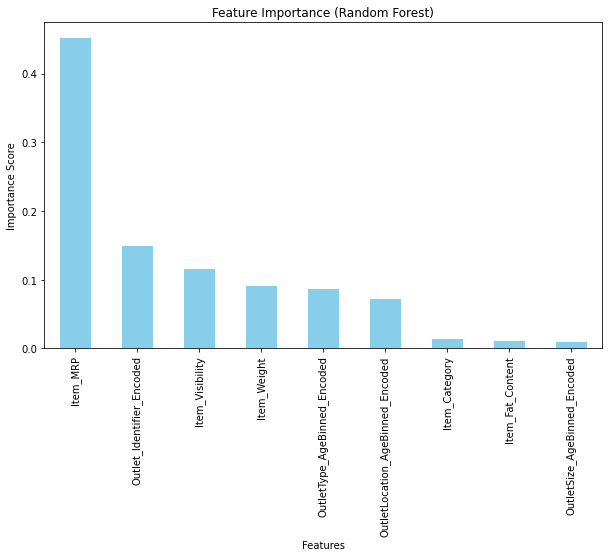

In [36]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort and visualize
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


In [37]:
feature_importance

Item_Weight                         0.090905
Item_Fat_Content                    0.010543
Item_Visibility                     0.114868
Item_MRP                            0.452020
Item_Category                       0.014255
Outlet_Identifier_Encoded           0.149042
OutletType_AgeBinned_Encoded        0.087129
OutletSize_AgeBinned_Encoded        0.009630
OutletLocation_AgeBinned_Encoded    0.071609
dtype: float64

In [38]:
# Drop least important features
low_importance_features = ['Item_Fat_Content', 'Item_Category', 'OutletSize_AgeBinned_Encoded']
X_train = X_train.drop(columns=low_importance_features)
X_validate = X_validate.drop(columns=low_importance_features)

print(f"Removed features: {low_importance_features}")


Removed features: ['Item_Fat_Content', 'Item_Category', 'OutletSize_AgeBinned_Encoded']


In [39]:
X_train

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier_Encoded,OutletType_AgeBinned_Encoded,OutletLocation_AgeBinned_Encoded
549,9.500,0.035206,171.3448,2.183970e+06,8.656284e+06,2.183970e+06
7757,18.000,0.047473,170.5422,2.036725e+06,8.656284e+06,6.472314e+06
764,17.600,0.076122,111.7202,2.118395e+06,2.118395e+06,2.118395e+06
6867,8.325,0.029845,41.6138,2.036725e+06,8.656284e+06,6.472314e+06
2716,12.850,0.137228,155.5630,2.118395e+06,2.118395e+06,2.118395e+06
...,...,...,...,...,...,...
5734,9.395,0.197746,139.1838,1.883402e+05,1.883402e+05,1.883402e+05
5191,15.600,0.117575,75.6670,2.167465e+06,8.656284e+06,6.472314e+06
5390,17.600,0.018944,237.3590,2.036725e+06,8.656284e+06,6.472314e+06
860,20.350,0.054363,117.9466,2.167465e+06,8.656284e+06,6.472314e+06


In [84]:
# Keep Item_Identifier & Outlet_Identifier for final submission
submission_ids = test_df[['Item_Identifier', 'Outlet_Identifier']]

# Define columns to exclude for model input
columns_to_exclude = [
    'Item_Outlet_Sales',  # Target variable
    'Item_Identifier',
    'Item_Base',
    'Item_Group',  # Used only for imputing missing values
    'Item_Type',  # Redundant after categorization into Item_Category
    'Outlet_Identifier',
    'Outlet_Total_Sales',
    'Outlet_Establishment_Year',  # Replaced by Outlet_Age
    'Outlet_Size',
    'Outlet_Size_Encoded',
    'Outlet_Location_Type',
    'Outlet_Type_Encoded',
    'Outlet_Type',
    'Outlet_Age',
    'Outlet_Age_Binned',
    'OutletType_AgeBinned',
    'Outlet_Age_Binned_Encoded',
    'Outlet_Age_Encoded',
    'Outlet_Location_Type_Encoded',
    'OutletLocation_AgeBinned',
    'Item_Fat_Content', 
    'Item_Category'
]

# Create X_test (features only)
X_test = test_df.drop(columns=columns_to_exclude, errors='ignore')

# Check the shape of X_test
print("X_test shape:", X_test.shape)

X_test shape: (5681, 6)


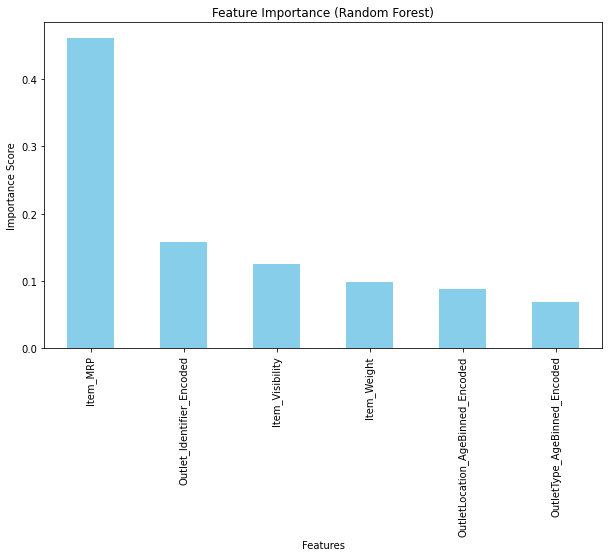

In [40]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort and visualize
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_pred = rf.predict(X_validate)

# Compute error metrics
mae = mean_absolute_error(y_validate, y_pred)
mse = mean_squared_error(y_validate, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 746.9000866087976
Mean Squared Error (MSE): 1144678.8207646122
Root Mean Squared Error (RMSE): 1069.896640224939
R² Score: 0.5788478928358889


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [10, 20, 30, 40, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in leaf
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features per split
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random settings to try
    scoring='neg_root_mean_squared_error',  # Optimize for lowest RMSE
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predict on validation set
y_pred = best_rf.predict(X_validate)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_validate, y_pred)
mse = mean_squared_error(y_validate, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Mean Absolute Error (MAE): 710.9542138520281
Mean Squared Error (MSE): 1037479.1392932945
Root Mean Squared Error (RMSE): 1018.5671992035158
R² Score: 0.6182889752775207


In [44]:
# Train RandomForest with optimized hyperparameters
rf = RandomForestRegressor(n_estimators=300, min_samples_split=5, 
                                   min_samples_leaf=4, max_features='log2', max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict on validation set
Y_pred = rf.predict(X_validate)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_validate, Y_pred)
mse = mean_squared_error(y_validate, Y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_validate, Y_pred)

print(f"New Model Performance After Removing Features:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


New Model Performance After Removing Features:
MAE: 710.9542138520281
MSE: 1037479.1392932945
RMSE: 1018.5671992035158
R² Score: 0.6182889752775207


In [112]:
import pandas as pd

# Define a dictionary of your datasets and filenames
datasets = {
    "X_train": X_train,
    "X_validate": X_validate,
    "y_train": y_train,
    "y_validate": y_validate,
    "train_df" : train_df,
    "test_df" : test_df,
    "X_test" : X_test
}

# Export each dataset to a CSV file
for name, df in datasets.items():
    df.to_csv(f"{name}.csv", index=False)
    print(f"Saved {name}.csv")

print("All datasets exported successfully! 🎉")


Saved X_train.csv
Saved X_validate.csv
Saved y_train.csv
Saved y_validate.csv
Saved train_df.csv
Saved test_df.csv
Saved X_test.csv
All datasets exported successfully! 🎉
